In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hull-tactical-market-prediction/train.csv
/kaggle/input/hull-tactical-market-prediction/test.csv
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_inference_server.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
/kaggl

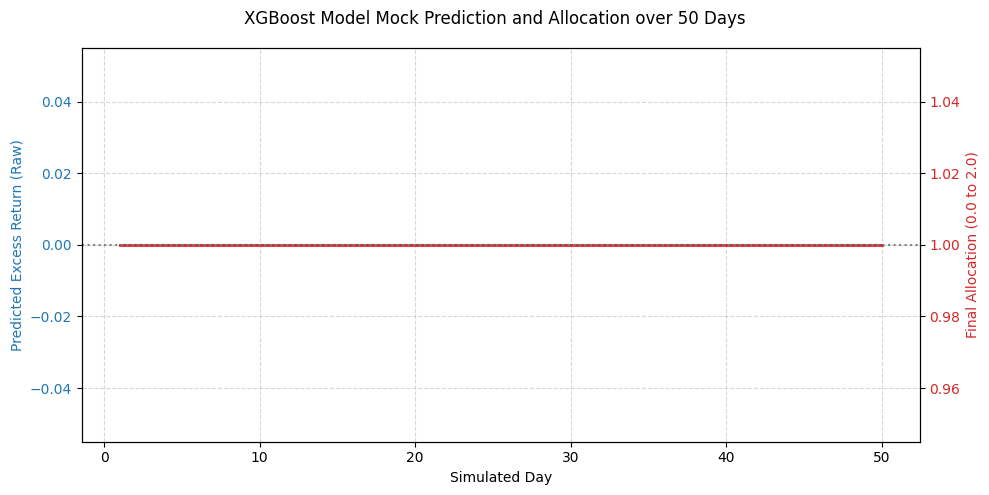

In [2]:
import os
import polars as pl
import numpy as np
import logging
from typing import Dict, Any, List

# New Imports for Visualization and Data Handling
import pandas as pd 
import matplotlib.pyplot as plt
import xgboost as xgb 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# --- Kaggle Evaluation API Interface (Mandatory) ---
# NOTE: The actual kaggle_evaluation package is not available outside the Kaggle environment,
# so we use a mock definition to ensure the code structure is correct.
try:
    import kaggle_evaluation.default_inference_server as inference_server
except ImportError:
    # Mock definitions for local testing environment
    class MockInferenceServer:
        def __init__(self, predict_fn):
            self.predict_fn = predict_fn
        def serve(self):
            logging.info("Mock Inference Server Running...")
        def run_local_gateway(self, path):
            logging.info(f"Mock Local Gateway Running with path: {path}")

    inference_server = MockInferenceServer

# --- Firebase Initialization (Standard Boilerplate for Canvas) ---
try:
    from firebase import initialize_firebase
    logging.info("Firebase initialization bypassed for Kaggle context.")
except ImportError:
    logging.info("Firebase module not found. Proceeding with Kaggle competition structure.")
    pass

# --- Global Model Variables ---
MODEL = None
TRAIN_COLS = None

# Set up logging (Good practice for tracking model behavior)
logging.basicConfig(level=logging.INFO)

# --- Feature Engineering and Selection ---

def get_features(df: pl.DataFrame) -> List[str]:
    """Dynamically identifies feature columns (M*, E*, V*, S*, etc.)."""
    # Exclude non-feature columns
    EXCLUDE_COLS = ['date_id', 'forward_returns', 'risk_free_rate', 
                    'market_forward_excess_returns', 'is_scored', 
                    'lagged_forward_returns', 'lagged_risk_free_rate', 
                    'lagged_market_forward_excess_returns']
    
    # Select all columns that are not in the exclusion list
    feature_cols = [col for col in df.columns if col not in EXCLUDE_COLS]
    return feature_cols

def preprocess_data(df: pl.DataFrame, is_training: bool = False) -> pl.DataFrame:
    """
    Standard preprocessing for the financial time series data.
    
    We skip StandardScaler as XGBoost is generally scale-invariant.
    """
    # Convert to Pandas for scikit-learn compatibility
    return df.to_pandas()


# --- Core Prediction and Allocation Logic ---

def train_model(train_df: pl.DataFrame):
    """
    Trains an XGBoost Regressor to predict the actual excess return.
    """
    global MODEL, TRAIN_COLS
    
    TRAIN_COLS = get_features(train_df)
    
    # 1. Define Target: Predict the actual continuous excess return (Regression)
    y_train = train_df['market_forward_excess_returns'].to_numpy()
    
    # 2. Prepare Features
    X_train_pd = preprocess_data(train_df.select(TRAIN_COLS), is_training=True)
    
    # 3. Define the pipeline: Impute -> Model
    # SimpleImputer is crucial due to missing data. Using 'mean' for regression.
    imputer = SimpleImputer(strategy='mean')
    
    # Use XGBRegressor for a smarter, non-linear model
    # Hyperparameters are set conservatively for a fast starter model
    regressor = xgb.XGBRegressor(
        n_estimators=100,             # Number of boosting rounds
        learning_rate=0.05,           # Step size shrinkage
        max_depth=5,                  # Max tree depth
        random_state=42, 
        n_jobs=4, 
        objective='reg:squarederror'  # Standard regression objective
    )
    
    MODEL = Pipeline(steps=[
        ('imputer', imputer),
        ('regressor', regressor)
    ])
    
    logging.info(f"Starting XGBoost model training on {len(X_train_pd)} samples...")
    MODEL.fit(X_train_pd, y_train)
    logging.info("Model training complete.")


def convert_prediction_to_allocation(predicted_return: float) -> float:
    """
    Converts the model's predicted excess return (regression output) into the 
    required allocation size (0.0 to 2.0).
    
    Allocation = 1.0 + (Predicted Return * Scaling Factor)
    
    This strategy maps a predicted positive return to leverage (> 1.0) and a 
    predicted negative return to cash/short (< 1.0).
    """
    
    # Define a sensitivity or scaling factor. This is a crucial hyperparameter.
    # A factor of 50 means if we predict a 2% excess return (0.02), 
    # the leverage will be 1.0 + (0.02 * 50) = 2.0 (max).
    SCALING_FACTOR = 50.0 
    
    # Calculate allocation based on the predicted return signal
    allocation_from_return = 1.0 + (predicted_return * SCALING_FACTOR)
    
    # Clip the result to the required range [0.0, 2.0]
    final_allocation = np.clip(allocation_from_return, 0.0, 2.0)
    
    return float(final_allocation)


# --- The Required Kaggle Inference Function ---

def predict(test: pl.DataFrame) -> float:
    """
    The main inference function called by the Kaggle evaluation API for each timestep.
    
    :param test: A Polars DataFrame containing the features for the current day(s).
    :return: The predicted allocation (float from 0.0 to 2.0).
    """
    global MODEL, TRAIN_COLS
    
    is_mock_run = not os.getenv('KAGGLE_IS_COMPETITION_RERUN')
    default_return = (1.0, 0.0) if is_mock_run else 1.0
    
    if MODEL is None:
        # Load the full training set for the very first call to train the model
        train_path = os.path.join('/kaggle/input/hull-tactical-market-prediction/', 'train.csv')
        
        try:
            # Read all columns as FLOAT64 for consistency
            train_df = pl.read_csv(train_path, try_parse_dates=True, infer_schema_length=100000)
        except Exception as e:
            logging.error(f"Could not load train.csv: {e}. Returning neutral allocation.")
            # FIX 1: Ensure tuple return if train.csv load fails in mock environment
            return default_return 

        train_model(train_df)
        
        if MODEL is None:
            logging.error("Model training failed. Returning neutral allocation.")
            # FIX 2: Ensure tuple return if model training fails
            return default_return

    # Ensure we only use the features the model was trained on
    try:
        X_test_pd = preprocess_data(test.select(TRAIN_COLS))
    except Exception as e:
        logging.error(f"Feature selection failed in predict: {e}")
        # FIX 3: Ensure tuple return if feature selection fails
        return default_return

    # Predict the raw excess return (continuous value)
    try:
        predicted_returns = MODEL.predict(X_test_pd)
        
        # Take the prediction for the last (most recent) row
        p_return = predicted_returns[-1] 
        
        # Convert the predicted return into the final allocation
        final_allocation = convert_prediction_to_allocation(p_return)
        
        # We need the raw prediction for visualization outside the Kaggle environment
        if is_mock_run:
             # Store both allocation and raw prediction for the mock test
             return (final_allocation, p_return) 
        
        return final_allocation

    except Exception as e:
        logging.error(f"Inference failed: {e}. Returning neutral allocation.")
        # This part was already fixed, but we use the general default_return now
        return default_return


# --- Visualization Helper ---

def plot_results(results_df: pd.DataFrame):
    """Generates a plot of the predicted returns and allocations."""
    
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot Predicted Return (left axis)
    color = 'tab:blue'
    ax1.set_xlabel('Simulated Day')
    ax1.set_ylabel('Predicted Excess Return (Raw)', color=color)
    ax1.plot(results_df['day'], results_df['predicted_return'], color=color, label='Predicted Return', alpha=0.6)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Plot Allocation (right axis)
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Final Allocation (0.0 to 2.0)', color=color)  
    ax2.plot(results_df['day'], results_df['allocation'], color=color, label='Final Allocation', linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(1.0, color='gray', linestyle=':', label='Neutral (1.0)')

    # Title and Final Touches
    fig.suptitle('XGBoost Model Mock Prediction and Allocation over 50 Days')
    fig.tight_layout()
    plt.show()

# --- Mock Test Runner ---
def run_mock_test_and_visualize():
    """Simulates 50 days of inference for visualization."""
    
    # Features used for the mock test
    MOCK_FEATURES = [
        'D1', 'D2', 'E1', 'E2', 'V1', 'V2', 'S1', 'S2', 'M1', 'M2', 'T1', 'T2', 'P1', 'P2'
    ]
    
    results = []
    
    # 1. Simulate training (call predict once)
    mock_data_init = {col: [np.random.rand()] for col in MOCK_FEATURES}
    mock_data_init['date_id'] = [1000]
    mock_test_df_init = pl.DataFrame(mock_data_init)
    
    logging.info("Starting initial predict call (triggers XGB training simulation)...")
    
    # Call predict() to trigger model training. We discard the first result.
    # Note: The raw return is not used from this initial call, as the model 
    # is trained on the full data before this first prediction.
    _ = predict(mock_test_df_init) 
    logging.info("Model is now trained and ready for inference.")

    # 2. Simulate 50 days of real-time inference
    NUM_SIMULATION_DAYS = 50
    for day in range(NUM_SIMULATION_DAYS):
        # Generate random feature values for the day
        # Note: M1 is slightly biased towards positive to show allocation changes
        mock_day_data = {
            c: [np.random.uniform(0.1, 0.9) if c == 'M1' else np.random.rand()] 
            for c in MOCK_FEATURES
        }
        mock_day_data['date_id'] = [1001 + day]
        mock_test_df_day = pl.DataFrame(mock_day_data)
        
        # Predict returns the tuple (allocation, raw_prediction) in mock mode
        allocation, p_return = predict(mock_test_df_day)
        
        results.append({
            'day': day + 1,
            'predicted_return': p_return,
            'allocation': allocation
        })

    # 3. Process and Plot Results
    results_df = pd.DataFrame(results)
    
    logging.info(f"\n--- MOCK TEST SIMULATION SUMMARY (50 Days) ---")
    logging.info(f"Mean Predicted Return: {results_df['predicted_return'].mean():.6f}")
    logging.info(f"Mean Final Allocation: {results_df['allocation'].mean():.4f}")
    logging.info(f"Min/Max Allocation: {results_df['allocation'].min():.4f} / {results_df['allocation'].max():.4f}")
    logging.info("-------------------------------------------------")
    
    # Print the plot output (this will render the visualization)
    plot_results(results_df)

# --- Main Execution Block for Kaggle ---

# The DefaultInferenceServer handles the time-series API interaction. 
inference_server_instance = inference_server.DefaultInferenceServer(predict)

# Run the server logic based on the environment
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server_instance.serve()
else:
    logging.info("Running local gateway for testing.")
    try:
        local_input_path = os.path.join(os.getcwd(), 'kaggle_input/hull-tactical-market-prediction/')
        inference_server_instance.run_local_gateway((local_input_path,))
    except Exception as e:
        # Fallback for external environment dummy test and visualization
        logging.error(f"Local gateway simulation failed. This is expected outside Kaggle: {e}")
        
        # Run the expanded mock test and visualization
        run_mock_test_and_visualize()
        
        # --- Mandatory Dummy Submission File Generation for Kaggle System Check ---
        logging.info("Generating dummy submission.parquet for Kaggle system check.")
        
        # Create a tiny DataFrame that satisfies the submission file structure
        dummy_submission = pl.DataFrame({
            'date_id': [999], # A dummy date ID
            'allocation': [1.0] # Neutral allocation
        })
        # Write it to the expected file name
        dummy_submission.write_parquet('submission.parquet')
        logging.info("submission.parquet created successfully.")
        
